In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Circle
from skimage.io import imread, imsave

from predict import get_most_activated_roi

sys.path.append('../unet_2d')
from model import *

Using TensorFlow backend.


# Load Model

In [2]:
MODEL_NAME = '../unet_2d/best_proposed.hdf5'

model = unet_2d_res()
model.load_weights(MODEL_NAME)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Load Nodule Data

In [3]:
df = pd.read_csv('data/aapm_table.csv')
df.head()

,Scan Number,"Nodule Center x,y Position*",Nodule Center Image,image_paths
0,CT-Training-lc001,"120, 325",135.0,data/raw_data/CT-Training-lc001/01-03-2007-671...
1,CT-Training-lc002,"139, 359",70.0,data/raw_data/CT-Training-lc002/01-15-2007-603...
2,CT-Training-lc003,"375, 323",70.0,data/raw_data/CT-Training-lc003/01-12-2007-171...
3,CT-Training-lc008,"95, 328",65.0,data/raw_data/CT-Training-lc008/01-10-2007-684...
4,CT-Training-lc009,"145, 299",63.0,data/raw_data/CT-Training-lc009/01-03-2007-169...


# Example

80.tif
37 144
37 143
1.0


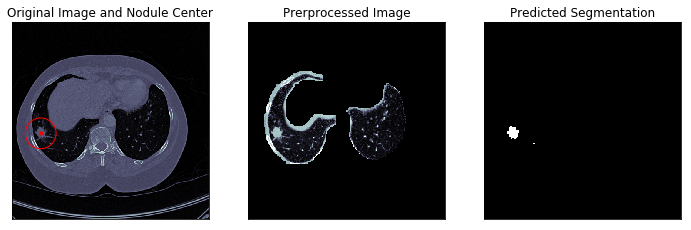

In [4]:
idx = os.listdir('data/aapm_processed')[np.random.randint(len(os.listdir('data/aapm_processed')))]
# idx='39.tif'
original = imread(f'data/aapm_extracted/{idx}') 
img = imread(f'data/aapm_processed/{idx}') 
print(idx)



pred = model.predict(img.reshape(1, 256, 256, 1)/255).reshape(256, 256)

row = df.iloc[int(idx[:-4])]
xx, yy = [int(p) for p in row['Nodule Center x,y Position*'].split(',')]
xx_true = xx//2
yy_true = yy//2
yy_hat, xx_hat = get_most_activated_roi(pred)
print(xx_true, yy_true)
print(xx_hat, yy_hat)
print(np.sqrt((xx_true-xx_hat)**2 + (yy_true-yy_hat)**2))


fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(original, cmap='bone')
axs[0].add_patch(Circle((xx, yy), 40, fill=False, ec='red'))
axs[0].scatter([xx], [yy], marker='.', color='red')

axs[1].imshow(img, cmap='bone')
axs[2].imshow(np.round(pred), cmap='bone')

axs[0].set_title("Original Image and Nodule Center")
axs[1].set_title("Prerprocessed Image")
axs[2].set_title("Predicted Segmentation")

axs[0].set_xticks([])
axs[1].set_xticks([])
axs[2].set_xticks([])
axs[0].set_yticks([])
axs[1].set_yticks([])
axs[2].set_yticks([])

plt.show()

# Evaluate

In [5]:
distances = []
for i, row in df.iterrows():
    sys.stdout.write(f"\r{i}")
    try:
        img = imread(f'data/aapm_processed/{i}.tif')
        pred = model.predict(img.reshape(1, 256, 256, 1)/255).reshape(256, 256)
        xx, yy = [int(p) for p in row['Nodule Center x,y Position*'].split(',')]
        xx_true = xx//2
        yy_true = yy//2
        yy_hat, xx_hat = get_most_activated_roi(pred)
        distances.append(np.sqrt((xx_true-xx_hat)**2 + (yy_true-yy_hat)**2))
    except FileNotFoundError:
        pass

82

In [6]:
distances=np.array(distances)
print(len(distances[distances<10])/len(distances))

0.8536585365853658
